In [1]:
import pybullet as p
import pybullet_data
import pkgutil
import numpy as np
import time

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import pickle

In [2]:
# Setup traj + scaling params.
data_file = open("../for_preston/pickled_data/traj_1.p", 'rb')
traj, obstacles = pickle.load(data_file)
data_file.close()

# Scale factors -- use to mess with spacing b/w robot and obstacles.
robot_scale = 0.7 
obs_shrink_factor = robot_scale / 8 # (this worked well empirically)

# Helper funcs to add obstacles / plane to PyBullet sim.
def add_obstacle(obstacle, height=0.2):
    half_extents = [((obstacle[1]-obstacle[0])/2) - obs_shrink_factor, 
                    ((obstacle[3]-obstacle[2])/2) - obs_shrink_factor, height/2]
    pos = [(obstacle[0] + obstacle[1])/2, (obstacle[2] + obstacle[3])/2, height/2]
    obs_vis_id = p.createVisualShape(p.GEOM_BOX, halfExtents=half_extents)
    obs_coll_id = p.createCollisionShape(p.GEOM_BOX, halfExtents=half_extents)
    p.createMultiBody(baseCollisionShapeIndex=obs_coll_id, baseVisualShapeIndex=obs_vis_id, 
                      basePosition=pos)

def add_ground_plane():
    half_extents = [0.3048*0.5*12, 0.3048*0.5*9, 0.01]
    obs_vis_id = p.createVisualShape(p.GEOM_BOX, halfExtents=half_extents, rgbaColor=[0.2, 0.2, 0.2, 1.])
    obs_coll_id = p.createCollisionShape(p.GEOM_BOX, halfExtents=half_extents)
    p.createMultiBody(baseCollisionShapeIndex=obs_coll_id, baseVisualShapeIndex=obs_vis_id, 
                      basePosition=half_extents)
    

MovieWriter ffmpeg unavailable; using Pillow instead.


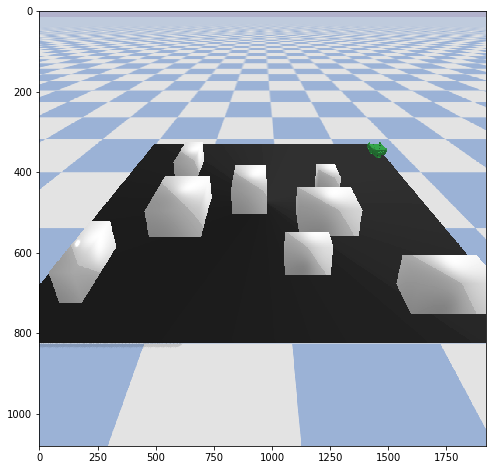

In [3]:
# main script
obs_data = obstacles

# PyBullet setup.
egl = pkgutil.get_loader('eglRenderer')
physicsClient = p.connect(p.DIRECT)
p.setAdditionalSearchPath(pybullet_data.getDataPath()) #optionally
plugin = p.loadPlugin(egl.get_filename(), "_eglRendererPlugin")
p.setGravity(0,0,-10)

# Load models from pybullet_data.
planeId = p.loadURDF("plane.urdf")
startPosition = [1.8,1.4, robot_scale]
startOrientation = p.getQuaternionFromEuler([0,0,np.pi/2])
astrobee = p.loadURDF("AstrobeeRobot.jl/deps/Astrobee/astrobee.urdf", 
                      basePosition=startPosition, baseOrientation=startOrientation,
                      flags=p.URDF_USE_INERTIA_FROM_FILE,
                      globalScaling=robot_scale)

# Setup movie parameters. 
fps = 30 # frames / sec
nSeconds = 10 # video length
nFrames = nSeconds * fps # total number of frames

# IMPORTANT: we don't want all the frames of the trajectory (10k is a ton).
# So, we compute a scaling to map GIF frames -> traj inds.
frame_scale = traj.shape[-1] / nFrames

# Camera params.
pixelWidth = w = 1920
pixelHeight = h = 1080
camTargetPos = [1.8, 1., 0]
camDistance = 2.5
pitch = -30.0
roll = 0
yaw = 0.
upAxisIndex = 2
viewMatrix = p.computeViewMatrixFromYawPitchRoll(camTargetPos, camDistance, yaw, pitch, roll,
                                                 upAxisIndex)
projectionMatrix = [
    1.0825318098068237, 0.0, 0.0, 0.0, 0.0, 1.732050895690918, 0.0, 0.0, 0.0, 0.0,
    -1.0002000331878662, -1.0, 0.0, 0.0, -0.020002000033855438, 0.0
]

# matplotlib setup.
fig = plt.figure( figsize=(8,8) )
im = plt.imshow(np.random.rand(pixelHeight, pixelWidth), interpolation='none', aspect='auto', vmin=0, vmax=1)

# Sim setup -- add plane + obs.
add_ground_plane()
for ii in range(len(obs_data[0])):
    add_obstacle([obs_data[jj][ii] for jj in range(4)])

# main animation loop:
def animate_func(ii):
    # Update robot position to ii-th animation frame.
    p.resetBasePositionAndOrientation(astrobee, [*traj[:2, int(frame_scale*ii)], 0.], startOrientation)
    
    # Get image from PyBullet.
    img_arr = p.getCameraImage(pixelWidth,
                           pixelHeight,
                           viewMatrix=viewMatrix,
                           projectionMatrix=projectionMatrix,
                           shadow=1,
                           lightDirection=[1, 1, 1])
    
    # Reshape to correct size + update artist object in matplotlib.
    rendering = img_arr[2].reshape((h, w, 4)) * (1. / 255.)
    im.set_array(rendering)
    return [im]

# Define animation parameters.
anim = animation.FuncAnimation(
                               fig,
                               animate_func,
                               frames = nFrames,
                               interval = 1000 / fps, # in ms
                               )

# Run through poses + write out to file -- change to .mp4 to make a video (requires ffmpeg).
anim.save('test_anim.gif', writer="ffmpeg")
p.disconnect()